In [123]:
import pandas as pd

traindata = pd.read_csv('files/csv/traindata.csv')
X = traindata[['lat', 'lng']]
Y = traindata['price_per_m2']

In [124]:
import random

def get_lat(lat):
    return lat + random.uniform(-0.000406*5, 0.000406*5)

def get_lng(lng):
    return lng + random.uniform(-0.000306*5, 0.000306*5)

# traindata_unique = traindata.groupby(['lat', 'lng']).quantile(q=0.5).reset_index()
# traindata_dup = pd.concat([traindata_unique] * 100, ignore_index=True)
# X = traindata_dup[['lat', 'lng']]
X['lat'] = X['lat'].apply(get_lat)
X['lng'] = X['lng'].apply(get_lng)
# Y = traindata_dup['price_per_m2']

/tmp/ipykernel_4051/2872633928.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lat'] = X['lat'].apply(get_lat)
/tmp/ipykernel_4051/2872633928.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lng'] = X['lng'].apply(get_lng)


In [125]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=2)

In [126]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_val = Y_val.reset_index(drop=True)

In [127]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
Y_train_scaled = Y_train/1e4

In [128]:
poly = PolynomialFeatures(degree=3).fit(X_train_scaled)
X_train_scaled = poly.transform(X_train_scaled)
X_val_scaled = poly.transform(X_val_scaled)

In [129]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
tf.random.set_seed(1234) # for consistent results

In [130]:
model = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.Input(shape=(10,)),
        tf.keras.layers.Dense(1, activation="relu"),
        ### END CODE HERE ### 
    ], name = "my_model" 
)

In [131]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=1000,
    decay_rate=0.5
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=optimizer
)

history = model.fit(
    X_train_scaled,
    Y_train_scaled.to_numpy().reshape(-1,1),
    epochs=10
)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 401695.1875
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 245104.7344
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 240881.5938
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 239814.8125
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 239452.4375
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 239266.2812
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 239151.9531
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 239078.2344
Epoch 9/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 239029.3438
Epoch 10/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 238996.2031


In [132]:
Y_train.reset_index(drop=True)[10]

12500000.0

In [133]:
res = model.predict(X_train_scaled[10].reshape(1,10)) * 1e4
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


array([[9354655.]], dtype=float32)

In [134]:
res = model.predict(X_val_scaled) * 1e4
res

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[9538787. ],
       [9412090. ],
       [2470540.2],
       ...,
       [5103520.5],
       [2254443.8],
       [8393660. ]], dtype=float32)

In [135]:
val_stats = Y_val - res.flatten()
val_stats = val_stats.sort_values()

In [136]:
top = int(0.9 * len(val_stats))
bot = int(0.1 * len(val_stats))

val_stats[bot:top].max(), val_stats[bot:top].min()

(5469310.0, -5275563.263157895)

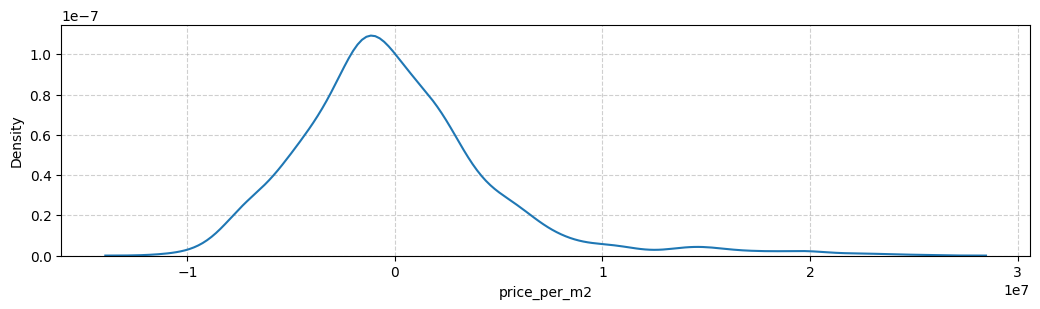

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,1, figsize=(12.5,3))
sns.kdeplot(ax=ax, data=val_stats.reset_index(drop=True).sort_values())

plt.xlabel("price_per_m2")
plt.ylabel("Density")
plt.grid(True, alpha=0.6, linestyle="--")
plt.show()